In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.style.use('ggplot')
# Required constants.
ROOT_DIR = '/media/dinh/New Volume/DAP_prj'
VALID_SPLIT = 0.1
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 16
NUM_WORKERS = 8 # Number of parallel processes for data preparation.

In [14]:
def save_model(epoch, model, optimizer, train_loss, valid_loss, train_epoch_acc, valid_epoch_acc, pretrained, finetune):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch,
                'pretrained': pretrained,
                'finetune': finetune,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_acc': train_epoch_acc,
                'valid_acc': valid_epoch_acc,
                }, f"{ROOT_DIR}/outputs/model_pretrained_best_valid_acc.pth")

In [15]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{ROOT_DIR}/outputs/accuracy_pretrained_{pretrained}.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{ROOT_DIR}/outputs/loss_pretrained_{pretrained}.png")

In [16]:
# Training transforms
def get_train_transform(IMAGE_SIZE, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform
# Validation transforms
def get_valid_transform(IMAGE_SIZE, pretrained):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform
# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize

In [17]:
def get_datasets(pretrained):
    """
    Function to prepare the Datasets.
    :param pretrained: Boolean, True or False.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset = datasets.ImageFolder(
        os.path.join(ROOT_DIR,'archive'), 
        transform=(get_train_transform(IMAGE_SIZE, pretrained))
    )
    dataset_valid_test = datasets.ImageFolder(
        os.path.join(ROOT_DIR,'archive'), 
        transform=(get_valid_transform(IMAGE_SIZE, pretrained))
    )
    dataset_size = len(dataset)
    # Calculate the validation dataset size.
    valid_size = int(VALID_SPLIT*dataset_size*2)
    # Radomize the data indices.
    if os.path.exists(os.path.join(ROOT_DIR,"shuffle_array.pth")):
        print("Loading older shuffle array")
        indices = torch.load(os.path.join(ROOT_DIR,"shuffle_array.pth"))
    else:
        indices = torch.randperm(len(dataset)).tolist()
        torch.save(indices, os.path.join(ROOT_DIR,"shuffle_array.pth"))
    # Training and validation sets.
    dataset_train = Subset(dataset, indices[:-valid_size*2])
    dataset_valid = Subset(dataset_valid_test, indices[-valid_size*2:-valid_size])
    dataset_test = Subset(dataset_valid_test, indices[-valid_size:])
    return dataset_train, dataset_valid, dataset_test ,dataset.classes
def get_data_loaders(dataset_train, dataset_valid, dataset_test):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    test_loader = DataLoader(
        dataset_test, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader, test_loader

In [18]:
# dataset_train, dataset_valid, dataset_test , classes = get_datasets(pretrained = True)

In [19]:
# classes
# len(dataset_train), len(dataset_test)

In [20]:
import torchvision.models as models
import torch.nn as nn
def build_model(pretrained=True, fine_tune=True, num_classes=10):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [21]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
# from model import build_model
# from datasets import get_datasets, get_data_loaders
# from utils import save_model, save_plots
# construct the argument parser
# parser = argparse.ArgumentParser()
# parser.add_argument(
#     '-e', '--epochs', type=int, default=20,
#     help='Number of epochs to train our network for'
# )
# parser.add_argument(
#     '-pt', '--pretrained', action='store_true',
#     help='Whether to use pretrained weights or not'
# )
# parser.add_argument(
#     '-lr', '--learning-rate', type=float,
#     dest='learning_rate', default=0.0001,
#     help='Learning rate for training the model'
# )
# args = vars(parser.parse_args())
args = {'epochs': 20, "pretrained": True, 'learning_rate': 0.0001, 'finetune': True}

In [22]:
# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    device = 'cuda'
    criterion.to(device)
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [23]:
# Validation function.
def validate(model, testloader, criterion):
    device = 'cuda'
    criterion.to(device)
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

Loading older shuffle array
[INFO]: Number of training images: 18602
[INFO]: Number of validation images: 6200
[INFO]: Class names: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 20

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


/home/dinh/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dinh/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


4,017,796 total parameters.
4,017,796 training parameters.
[INFO]: Epoch 1 of 20
Training


100%|██████████| 1163/1163 [02:25<00:00,  7.98it/s]

Validation



100%|██████████| 388/388 [00:22<00:00, 16.98it/s]


Training loss: 1.262, training acc: 52.570
Validation loss: 0.931, validation acc: 64.710
--------------------------------------------------
Writing new state dict
New best accuracy 64.70967741935483 

[INFO]: Epoch 2 of 20
Training


100%|██████████| 1163/1163 [02:21<00:00,  8.22it/s]

Validation



100%|██████████| 388/388 [00:25<00:00, 15.11it/s]


Training loss: 0.904, training acc: 66.455
Validation loss: 0.868, validation acc: 67.774
--------------------------------------------------
Writing new state dict
New best accuracy 67.7741935483871 

[INFO]: Epoch 3 of 20
Training


100%|██████████| 1163/1163 [02:14<00:00,  8.66it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.57it/s]


Training loss: 0.786, training acc: 71.299
Validation loss: 0.805, validation acc: 69.887
--------------------------------------------------
Writing new state dict
New best accuracy 69.88709677419355 

[INFO]: Epoch 4 of 20
Training


100%|██████████| 1163/1163 [02:14<00:00,  8.63it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.43it/s]


Training loss: 0.691, training acc: 74.675
Validation loss: 0.827, validation acc: 69.806
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████| 1163/1163 [02:14<00:00,  8.62it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.69it/s]


Training loss: 0.603, training acc: 77.868
Validation loss: 0.873, validation acc: 69.210
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████| 1163/1163 [02:14<00:00,  8.62it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.56it/s]


Training loss: 0.519, training acc: 81.147
Validation loss: 0.880, validation acc: 70.500
--------------------------------------------------
Writing new state dict
New best accuracy 70.5 

[INFO]: Epoch 7 of 20
Training


100%|██████████| 1163/1163 [02:16<00:00,  8.50it/s]

Validation



100%|██████████| 388/388 [00:23<00:00, 16.61it/s]


Training loss: 0.445, training acc: 84.045
Validation loss: 0.916, validation acc: 70.161
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.59it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.71it/s]


Training loss: 0.384, training acc: 86.136
Validation loss: 1.003, validation acc: 69.935
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.60it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.74it/s]


Training loss: 0.341, training acc: 87.867
Validation loss: 1.036, validation acc: 70.306
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.60it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.46it/s]


Training loss: 0.287, training acc: 89.802
Validation loss: 1.096, validation acc: 69.323
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.60it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.43it/s]


Training loss: 0.245, training acc: 91.453
Validation loss: 1.168, validation acc: 69.645
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.58it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 17.86it/s]


Training loss: 0.225, training acc: 91.990
Validation loss: 1.234, validation acc: 68.661
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████| 1163/1163 [02:17<00:00,  8.47it/s]

Validation



100%|██████████| 388/388 [00:23<00:00, 16.42it/s]


Training loss: 0.196, training acc: 92.990
Validation loss: 1.245, validation acc: 69.774
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████| 1163/1163 [02:16<00:00,  8.54it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.44it/s]


Training loss: 0.185, training acc: 93.517
Validation loss: 1.285, validation acc: 69.565
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████| 1163/1163 [02:16<00:00,  8.55it/s]

Validation



100%|██████████| 388/388 [00:23<00:00, 16.77it/s]


Training loss: 0.168, training acc: 94.194
Validation loss: 1.299, validation acc: 69.226
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.58it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.19it/s]


Training loss: 0.151, training acc: 94.786
Validation loss: 1.403, validation acc: 69.661
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.57it/s]

Validation



100%|██████████| 388/388 [00:22<00:00, 17.57it/s]


Training loss: 0.145, training acc: 94.904
Validation loss: 1.368, validation acc: 69.177
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████| 1163/1163 [02:16<00:00,  8.55it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.30it/s]


Training loss: 0.132, training acc: 95.226
Validation loss: 1.449, validation acc: 68.903
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████| 1163/1163 [02:15<00:00,  8.59it/s]

Validation



100%|██████████| 388/388 [00:21<00:00, 18.28it/s]


Training loss: 0.124, training acc: 95.710
Validation loss: 1.521, validation acc: 70.016
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████| 1163/1163 [02:16<00:00,  8.54it/s]

Validation



100%|██████████| 388/388 [00:22<00:00, 16.96it/s]


Training loss: 0.121, training acc: 95.807
Validation loss: 1.556, validation acc: 68.968
--------------------------------------------------
TRAINING COMPLETE


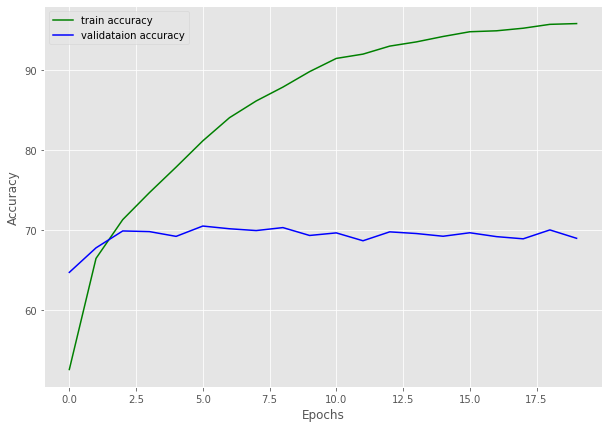

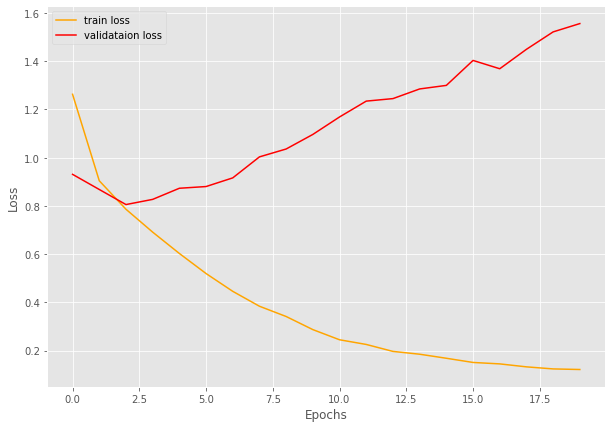

In [24]:
# if __name__ == '__main__':

# Load the training and validation datasets.
dataset_train, dataset_valid, dataset_test , dataset_classes = get_datasets(args['pretrained'])
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)
# Learning_parameters. 
lr = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=args['pretrained'], 
    fine_tune= args["finetune"], 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.AdamW(model.parameters(), lr=lr)

# get previous state dict 
if os.path.exists(os.path.join(ROOT_DIR,"outputs/model_pretrained_best_valid_acc.pth")):
    print("Loading previous state")
    previous = torch.load(os.path.join(ROOT_DIR,"outputs/model_pretrained_best_valid_acc.pth"))
    model.load_state_dict(previous["model_state_dict"])
    # optimizer.load_state_dict(previous["optimizer_state_dict"])
    best_valid_acc = previous["valid_acc"]
    print("best_valid_acc", best_valid_acc)
else:
    os.makedirs(os.path.join(ROOT_DIR,"outputs"), exist_ok= True)
    best_valid_acc = 0

# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    
    # Save the trained model weights.
    if valid_epoch_acc > best_valid_acc:
        print("Writing new state dict")
        save_model(epoch, model, optimizer, train_loss, valid_loss, train_epoch_acc, valid_epoch_acc, 
                    args['pretrained'], args["finetune"])
        best_valid_acc = valid_epoch_acc
        print("New best accuracy",best_valid_acc,"\n")
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss, args['pretrained'])
print('TRAINING COMPLETE')

In [25]:
# test 
dataset_train, dataset_valid, dataset_test , dataset_classes = get_datasets(args['pretrained'])
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)
device = 'cuda'
model = build_model(
    pretrained=args['pretrained'], 
    fine_tune= args["finetune"], 
    num_classes=len(dataset_classes)
).to(device)
best_state_dict = torch.load("outputs/model_pretrained_best_valid_acc.pth")
model.load_state_dict(best_state_dict["model_state_dict"])
valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
print(f"Test loss: {test_loss:.3f}, test acc: {test_acc:.3f}")

Loading older shuffle array
[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
Validation


100%|██████████| 388/388 [00:22<00:00, 16.99it/s]

Validation



100%|██████████| 388/388 [00:20<00:00, 18.50it/s]

Validation loss: 0.880, validation acc: 70.500
Test loss: 0.867, test acc: 70.968
